# Test repository in the building process

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### 1. Preprocessing

In [3]:
from load import load_data
train_df, submission_df = load_data()

In [4]:
from preprocess import preprocess

A_tilde, standardized_train_ratings, train_users, train_items, means, stds, val_users, val_items, orig_val_ratings, standardized_val_ratings, submission_users, submission_items = preprocess((train_df, submission_df))

### 2. Train
L=1, K=30, INIT_EMBS_STD=0.075, LR=0.075, WEIGHT_DECAY=1e-05, DROPOUT=0.4

In [5]:
# Model and optimizer hyperparameters
L=1
K=32
INIT_EMBS_STD=0.05
LR=0.025
WEIGHT_DECAY=1e-05
DROPOUT=0.2
NUM_HEADS=4

# Train loop hyperparameters
EPOCHS=2000
STOP_THRESHOLD=1e-06

In [6]:
from train import train_model
from models import ConcatNonLinear_41out, ConcatNonLinear_42out, ConcatNonLinear_421out, ConcatNonLinear
from config import DEVICE

# model = ConcatNonLinear_41out(A_tilde, K, L, INIT_EMBS_STD, DROPOUT).to(DEVICE)
model = ConcatNonLinear(A_tilde, K, L, INIT_EMBS_STD, DROPOUT, NUM_HEADS).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss()

c:\Users\soljt\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from train import train_model
# model, optimizer, loss_fn, train_users, train_items, train_ratings, val_users, val_items, val_ratings, n_epochs, improvement_threshold) -> tuple[list, list]:
train_rmse, val_rmse_std, val_rmse_orig = train_model(model, optimizer, loss_fn, train_users, train_items, standardized_train_ratings, val_users, val_items, orig_val_ratings, standardized_val_ratings, means, stds, EPOCHS, STOP_THRESHOLD, True, hyper_verbose=True)

Epoch 0 - Train loss: 1.0097 - Val loss standardized: 1.0128 - Val loss original: 1.0703
Epoch 1 - Train loss: 1.0001 - Val loss standardized: 1.0141 - Val loss original: 1.0715
Epoch 2 - Train loss: 1.0001 - Val loss standardized: 1.0147 - Val loss original: 1.0725
Epoch 3 - Train loss: 1.0061 - Val loss standardized: 1.0161 - Val loss original: 1.0734
Epoch 4 - Train loss: 1.0008 - Val loss standardized: 1.0164 - Val loss original: 1.0737
Epoch 5 - Train loss: 1.0010 - Val loss standardized: 1.0054 - Val loss original: 1.0622
Epoch 6 - Train loss: 0.9924 - Val loss standardized: 1.0032 - Val loss original: 1.0601
Epoch 7 - Train loss: 0.9946 - Val loss standardized: 0.9988 - Val loss original: 1.0553
Epoch 8 - Train loss: 0.9891 - Val loss standardized: 0.9969 - Val loss original: 1.0531
Epoch 9 - Train loss: 0.9845 - Val loss standardized: 1.0017 - Val loss original: 1.0579
Epoch 10 - Train loss: 0.9876 - Val loss standardized: 0.9927 - Val loss original: 1.0484
Epoch 11 - Train los

### 3. Check training results

Min training loss: 0.9756245017051697
Min validation loss std: 0.9849252104759216
Min validation loss orig: 1.0401651859283447
Min validation loss at epoch: 37


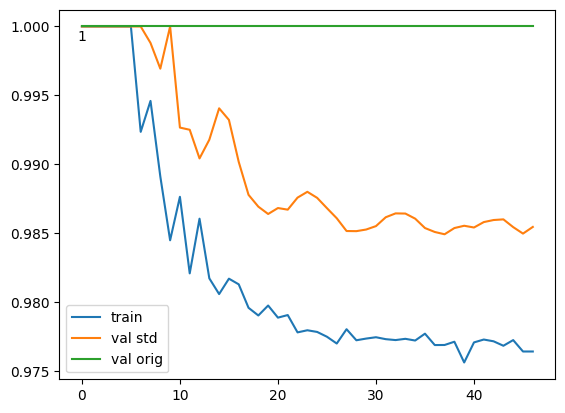

In [9]:
# Training stats

print("Min training loss:", min(train_rmse))
print("Min validation loss std:", min(val_rmse_std))
print("Min validation loss orig:", min(val_rmse_orig))
print("Min validation loss at epoch:", val_rmse_std.index(min(val_rmse_std)))

# Replace values above 10 with 10 in the rmse lists
train_rmse_plot = [min(1, x) for x in train_rmse]
val_rmse_std_plot = [min(1, x) for x in val_rmse_std]
val_rmse_orig_plot = [min(1, x) for x in val_rmse_orig]

# Plot train and val rmse
plt.plot(train_rmse_plot, label='train')
plt.plot(val_rmse_std_plot, label='val std')
plt.plot(val_rmse_orig_plot, label='val orig')
plt.plot()
# annotate min val loss
plt.annotate(round(min(val_rmse_orig_plot), 4), (val_rmse_orig_plot.index(min(val_rmse_orig_plot)), min(val_rmse_orig_plot)), textcoords="offset points", xytext=(0,-10), ha='center')
plt.legend()
plt.show()

### 4. Post-processing

In [10]:
# Read model that achieved best validation loss
model.eval()
model.load_state_dict(torch.load("../data/logs/best_val_model.pth"))

# Get predictions for submission
final_ratings = model.get_ratings(submission_users, submission_items).cpu().detach().numpy()

min: -0.6850378
max: 0.974304
mean: 0.0030017297


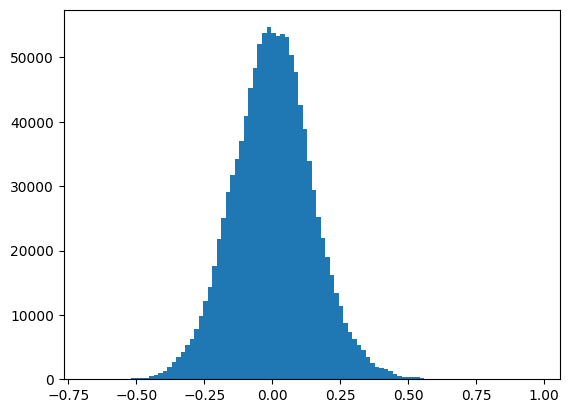

In [11]:
# Check min and max of final_ratings
print("min:", final_ratings.min())
print("max:", final_ratings.max())
print("mean:", final_ratings.mean())

# Check distribution of final_ratings
plt.hist(final_ratings.flatten(), bins=100)
plt.show()

In [12]:
from config import N_u, N_v
# Reverse standardization

# Fill matrix with predictions
final_ratings_matrix = np.zeros((N_u, N_v))
final_ratings_matrix[submission_users, submission_items] = final_ratings

# Reverse standardization (no mask needed)
def reverse_standardization(submission_matrix, means, stds):
    # shape of all inputs: (n_users, n_items)
    reversed_ratings = submission_matrix * stds + means
    return reversed_ratings

final_ratings_matrix = reverse_standardization(final_ratings_matrix, means, stds)

# extract numpy array from ratings matrix
final_ratings = final_ratings_matrix[submission_users, submission_items]

In [13]:
# Clip at 1 and 5

# check min and max of final_ratings_rounded
print("min:", final_ratings.min().item())
print("max:", final_ratings.max().item())
print("mean:", final_ratings.mean().item())

# Count the number of values under 1 and over 5
count_under_1 = (final_ratings < 1).sum().item()
count_over_5 = (final_ratings > 5).sum().item()
print("count_over_5:", count_over_5)
print("count_under_1:", count_under_1)

# Clip the values to be within the range [1, 5]
final_ratings = np.clip(final_ratings, 1, 5)

min: 1.4457258146753964
max: 5.404507683780466
mean: 3.859828527857161
count_over_5: 102
count_under_1: 0


min: 1.4457258146753964
max: 5.0
mean: 3.859821344210862


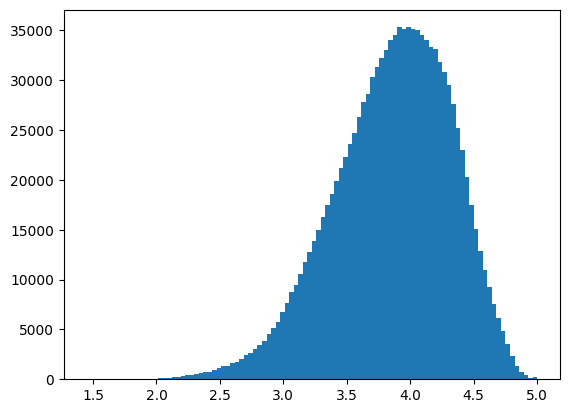

In [14]:
# check min and max of final_ratings
print("min:", final_ratings.min().item())
print("max:", final_ratings.max().item())
print("mean:", final_ratings.mean().item())

# check distribution of final_ratings
plt.hist(final_ratings.flatten(), bins=100)
plt.show()

### 5. Submission

In [15]:
# save submission
def to_submission_format(users, movies, predictions):
    return pd.DataFrame(data={'Id': ['r{}_c{}'.format(user + 1, movie + 1) for user, movie in zip(users, movies)],
                              'Prediction': predictions})

submission = to_submission_format(submission_users, submission_items, final_ratings)

submission.to_csv('../data/submission_data/submission.csv', index=False)